/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/190 [00:00<?, ?B/s]

model.png:   0%|          | 0.00/39.2k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

variables/variables.index:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/23.1k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/9.33M [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/261k [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 56ms/step
Image 1: PSNR=17.43, SSIM=0.8516, MSE=0.0723
Image 2: PSNR=13.30, SSIM=0.7442, MSE=0.1871
Image 3: PSNR=21.21, SSIM=0.8853, MSE=0.0303
Image 4: PSNR=12.30, SSIM=0.6462, MSE=0.2354
Image 5: PSNR=17.31, SSIM=0.8229, MSE=0.0744
Image 6: PSNR=11.42, SSIM=0.5258, MSE=0.2884
Image 7: PSNR=13.46, SSIM=0.7086, MSE=0.1802
Image 8: PSNR=20.13, SSIM=0.8905, MSE=0.0388
Image 9: PSNR=12.77, SSIM=0.6483, MSE=0.2115
Image 10: PSNR=15.89, SSIM=0.7525, MSE=0.1031
Average PSNR: 15.52
Average SSIM: 0.7476
Average MSE: 0.1421


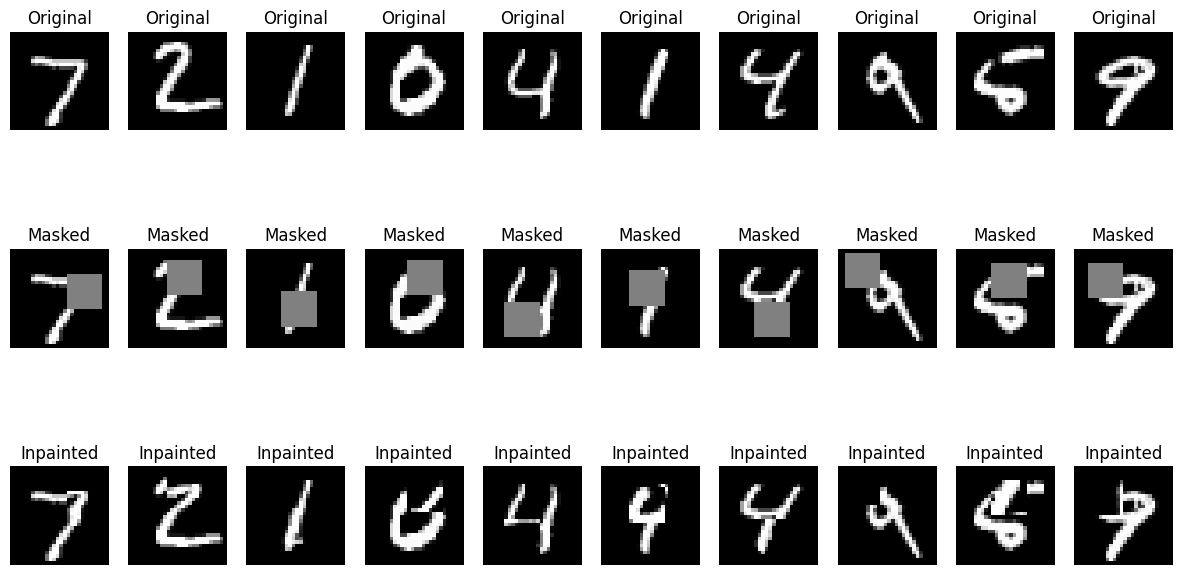

Overall Average PSNR: 16.58
Overall Average SSIM: 0.7650
Overall Average MSE: 0.1236


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from huggingface_hub import from_pretrained_keras
from tensorflow.keras.datasets import mnist
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error as mse

# Load the pre-trained generator model from Hugging Face Hub
generator = from_pretrained_keras("nathanReitinger/MNIST-GAN")

# Load the MNIST dataset
(_, _), (X_test, _) = mnist.load_data()

# Normalize the dataset
X_test = (X_test.astype(np.float32) - 127.5) / 127.5
X_test = np.expand_dims(X_test, axis=-1)  # Reshape to (num_samples, 28, 28, 1)

# Function to mask parts of the images
def mask_image(image, mask_size=10):
    masked_image = np.copy(image)
    top_left_x = np.random.randint(0, image.shape[0] - mask_size)
    top_left_y = np.random.randint(0, image.shape[1] - mask_size)
    masked_image[top_left_x:top_left_x + mask_size, top_left_y:top_left_y + mask_size, :] = 0
    return masked_image, (top_left_x, top_left_y, mask_size)

masked_images = []
original_images = []
mask_coords_list = []

for img in X_test:
    masked_img, mask_coords = mask_image(img)
    masked_images.append(masked_img)
    original_images.append(img)
    mask_coords_list.append(mask_coords)

masked_images = np.array(masked_images)
original_images = np.array(original_images)

# Function to inpaint image
def inpaint_image(generator, masked_image, mask_coords):
    mask_x, mask_y, mask_size = mask_coords
    noise = np.random.normal(0, 1, (1, 100))

    # Get the generated image from the noise
    generated_image = generator.predict(noise)[0]

    # Use the generated image to fill in the masked region of the masked image
    inpainted_image = np.copy(masked_image)
    inpainted_image[mask_x:mask_x + mask_size, mask_y:mask_y + mask_size, :] = generated_image[mask_x:mask_x + mask_size, mask_y:mask_y + mask_size, :]

    return inpainted_image

inpainted_images = []

for masked_img, mask_coords in zip(masked_images, mask_coords_list):
    inpainted_img = inpaint_image(generator, masked_img, mask_coords)
    inpainted_images.append(inpainted_img)

inpainted_images = np.array(inpainted_images)

# Function to visualize the results and print metrics
def plot_images(original, masked, inpainted, n=10):
    plt.figure(figsize=(15, 8))
    psnr_values = []
    ssim_values = []
    mse_values = []

    for i in range(n):
        plt.subplot(3, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Original")

        plt.subplot(3, n, i + 1 + n)
        plt.imshow(masked[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Masked")

        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(inpainted[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Inpainted")

        # Calculate and print PSNR
        psnr_value = psnr(original[i].reshape(28, 28), inpainted[i].reshape(28, 28), data_range=2)
        ssim_value = ssim(original[i].reshape(28, 28), inpainted[i].reshape(28, 28), data_range=2)
        mse_value = mse(original[i].reshape(28, 28), inpainted[i].reshape(28, 28))

        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)
        mse_values.append(mse_value)

        print(f"Image {i + 1}: PSNR={psnr_value:.2f}, SSIM={ssim_value:.4f}, MSE={mse_value:.4f}")

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)
    avg_mse = np.mean(mse_values)

    print(f"Average PSNR: {avg_psnr:.2f}")
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average MSE: {avg_mse:.4f}")

    plt.show()

    # Visualize and evaluate a subset of the results for brevity
# You can adjust n to visualize more images if needed
n = 10
plot_images(original_images, masked_images, inpainted_images, n=n)

# Calculate overall accuracy metrics for the entire dataset
psnr_values = []
ssim_values = []
mse_values = []

for original, inpainted in zip(original_images, inpainted_images):
    psnr_values.append(psnr(original.reshape(28, 28), inpainted.reshape(28, 28), data_range=2))
    ssim_values.append(ssim(original.reshape(28, 28), inpainted.reshape(28, 28), data_range=2))
    mse_values.append(mse(original.reshape(28, 28), inpainted.reshape(28, 28)))

avg_psnr = np.mean(psnr_values)
avg_ssim = np.mean(ssim_values)
avg_mse = np.mean(mse_values)

print(f"Overall Average PSNR: {avg_psnr:.2f}")
print(f"Overall Average SSIM: {avg_ssim:.4f}")
print(f"Overall Average MSE: {avg_mse:.4f}")